In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import os
import scipy.sparse as sparse
from test import *

from itertools import chain
from pathlib import *
from math import ceil
from sqlalchemy import create_engine
from pandarallel import pandarallel

from test import *
from helper import *
from tree_weight import *
from time import time
from main import make_graph_from_tree
from multiprocessing import *

from typing import List
%matplotlib inline

In [3]:
image_folder = 'graphs/'
tree = 'benchmark_models/golomb/trees/08.sqlite'
info_df = to_df(tree, 'info').set_index('NodeID')
nodes_df = to_df(tree, 'nodes').set_index('NodeID')
valid_df = nodes_df[nodes_df['Status'] != 3]

print(nodes_df.shape)

(5980, 5)


In [6]:
test_df = pd.DataFrame.copy(nodes_df)
test_df = test_df.drop(columns=['DFSOrdering', 'SubtreeSize'])

KeyError: "['DFSOrdering' 'SubtreeSize'] not found in axis"

In [8]:
%%time
calculate_subtree_size(test_df)

# init
parentIds = {0}
test_df.loc[:, 'DFSOrdering'] = np.nan
test_df.loc[0, 'DFSOrdering'] = 0

# set up init values
total_children_count = test_df['ParentID'].isin(parentIds).sum()
first_children = test_df[(test_df['ParentID'].isin(parentIds)) & (test_df['Alternative'] == 0)].index.to_numpy()
current_alternative = 0

while total_children_count > 0:

    # set first childrent to have DFS Order = parent + 1
    test_df.loc[first_children, 'DFSOrdering'] = get_parent_column('DFSOrdering', test_df).loc[first_children] + 1
    
    # second and so on children have DFS Order = older sibling + older sibling's subtree
    # iterate over higher alternatives
    
    # accumulaive parent ids
    new_parent_ids = set()
    
    # set up init values
    new_parent_ids = new_parent_ids.union(set(first_children))
    current_children = first_children
    temp_current = test_df.loc[first_children, :].reset_index().set_index('ParentID') # holds DFS order of first children indexed by parent id
    total_children_count -= len(first_children)
    current_alternative += 1
    while total_children_count > 0:
        next_children = test_df[(test_df['ParentID'].isin(parentIds)) & (test_df['Alternative'] == current_alternative)].index.to_numpy()
        temp_next = test_df.loc[next_children, :].reset_index().set_index('ParentID')
        temp_next.loc[:, 'DFSOrdering'] = temp_current['DFSOrdering'] + temp_current['SubtreeSize']
        temp_next = temp_next.reset_index().set_index('NodeID') # holds DFS of next children indexed by parent id
        test_df.loc[next_children, 'DFSOrdering'] = temp_next
        # reset loop variables
        total_children_count -= len(next_children)
        temp_current = temp_next.reset_index().set_index('ParentID')
        current_alternative += 1
        new_parent_ids = new_parent_ids.union(set(next_children))

    # set parent again
    parentIds = new_parent_ids
    
    # compute outer loop variables again
    total_children_count = test_df['ParentID'].isin(parentIds).sum()
    first_children = test_df[(test_df['ParentID'].isin(parentIds)) & (test_df['Alternative'] == 0)].index.to_numpy()
    current_alternative = 0
    
test_df.loc[:, 'DFSOrdering'] = test_df['DFSOrdering'].astype(int)
test_df.loc[test_df[test_df['Status'] == 3].index, 'DFSOrdering'] = -1

CPU times: user 2.31 s, sys: 0 ns, total: 2.31 s
Wall time: 2.31 s


In [9]:
test_df['DFSOrdering']

NodeID
0          0
1          1
2       2962
3       4283
4       5041
        ... 
5975    5925
5976    5926
5977    5927
5978    5928
5979    5929
Name: DFSOrdering, Length: 5980, dtype: int64

In [20]:
%%time
dfs_ordering = make_dfs_ordering(nodes_df)
nodes_df['DFSOrdering'] = -1
nodes_df.loc[dfs_ordering, 'DFSOrdering'] = range(len(dfs_ordering))
nodes_df.loc[:, 'DFSOrdering'] = nodes_df['DFSOrdering'].astype(int)

CPU times: user 6.19 s, sys: 3.88 ms, total: 6.19 s
Wall time: 6.2 s


In [22]:
(test_df['DFSOrdering'] != nodes_df['DFSOrdering']).sum()

0

# NOTE:
DES without adaptive resolution falls apart in sudden upwards trajectory of cumulative weight, which is the very thing we had wanted DES to accomodate too. Thus, it may be better to update with larger distance

In [75]:
cum_sums_leaves = cum_sums['Subtree'].\
                    loc[nodes_df[nodes_df['Status'].isin({0, 1})]\
                    ['DFSOrdering']].sort_values() # filtered out non-leaves

# parameters
a = 0.1
b = 0.001

smoothed_subtreesize = get_exp_smoothed_cum_weight(nodes_df, cum_sums_leaves, a=a, b=b, adaptive_resolution=True)

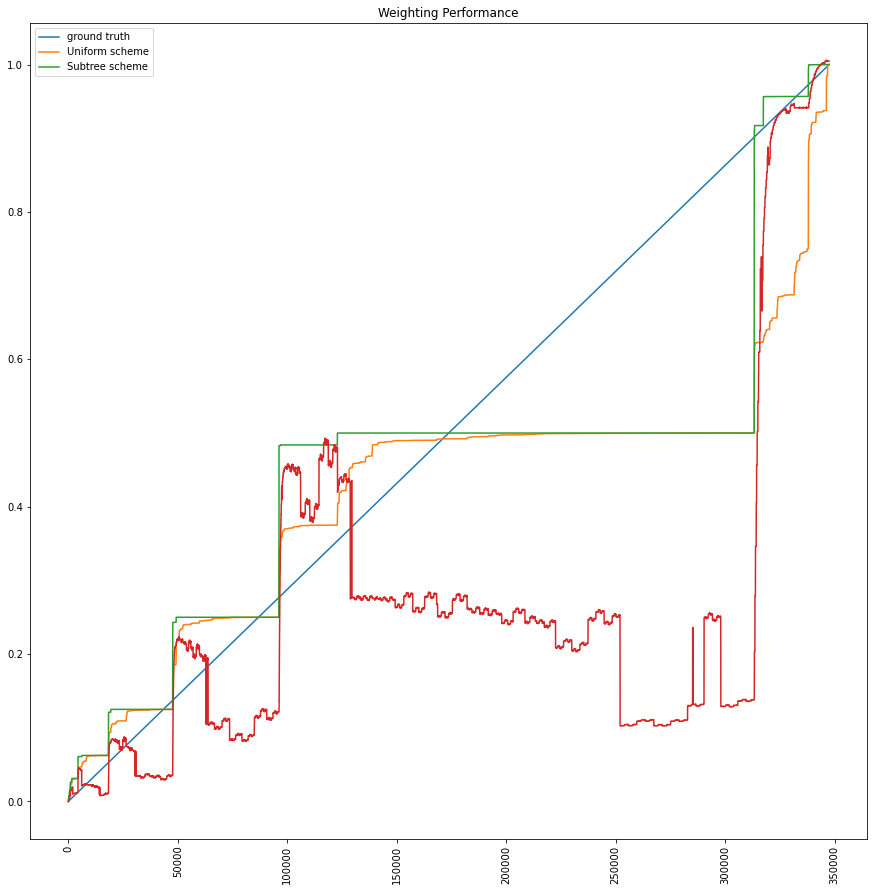

In [76]:
plot_goodness(cum_sums)
plt.plot(smoothed_subtreesize)

In [66]:
smoothed_subtreesize

0         0.00000
1         0.00000
2         0.00000
3         0.00000
4         0.00000
           ...   
347551    0.99972
347552    0.99972
347553    0.99972
347554    0.99972
347555    0.99972
Name: completion, Length: 347556, dtype: float64